In [1]:
import torch 
from PIL import Image

from lavis.models import load_model_and_preprocess

/home/ommos92/miniconda3/envs/lavis_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

class WGVDataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        
        self.image_folder = image_folder
        self.csv_file = csv_file
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the city name from the CSV file
        city = self.data.iloc[idx, 0]  # assuming the city name is in the first column

        # Expand the tilde ~ in the image folder path to the home directory
        image_folder = os.path.expanduser(self.image_folder)

        # Find the image file in the image folder that contains the city name
        for filename in os.listdir(image_folder):
            if city in filename:
                img_path = os.path.join(image_folder, filename)
                break
        else:
            raise FileNotFoundError(f"No image file containing '{city}' found in the image folder")

        # Open the image file
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        state = self.data.iloc[idx, 1]
        country = self.data.iloc[idx, 2]
        continent = self.data.iloc[idx, 3]

        return image, state, country, continent

# Define the paths to the image folder and CSV file
image_folder = "~/.cache/lavis/WGV/val"
csv_file = "~/.cache/lavis/WGV/labels_list.csv"

# Define any additional transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [30]:

# Create an instance of the LocationDataset
dataset = WGVDataset(image_folder, csv_file, transform)

# Create a DataLoader to load the data in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


State: Abu_Dhabi
Country: United_Arab_Emirates
Continent: Asia


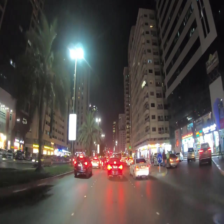

In [31]:
# Load a sample image
image, state, country, continent = dataset[0]

# Show the image state, country, and continent
print("State:", state)
print("Country:", country)
print("Continent:", continent)

# Show the image
# Convert the Tensor object to a PIL.Image object
image_pil = transforms.ToPILImage()(image)

# Show the image
image_pil.show()


## Load the BLIP-2 VQA Model


In [ ]:
# setup device to use
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
#Load the model
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
)
